<a href="https://colab.research.google.com/github/someshjaishwal/image-segmentation/blob/master/basic_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [0]:
from IPython.display import clear_output as clear
import glob
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import cv2
import pickle

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import MeanShift
from skimage import segmentation, color, data
from sklearn.mixture import BayesianGaussianMixture
from skimage.future import graph

#
# pytorch specific
#

import torch
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary



from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# Mount Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

gdrive = '/gdrive/My\ Drive/'
clear()

In [0]:
!tar -xf $gdrive/dataset/IITK_Dataset.tar.gz

# Image Segmentation

## Dataset

This section implements the following:

* Build Dataset
* Split Dataset
* Stage Dataset

In [0]:
#
# Build Dataset
#

class iitk_dataset(torch.utils.data.Dataset): 
  
    def __init__(self, image_paths, transform=None):

        # initialize img paths
        self.image_paths = image_paths

        # image transformations
        self.transform = transform
        
        # randomize indices
        self.random_indices = np.arange(len(self.image_paths))
        np.random.shuffle(self.random_indices)
        
        
    def __len__(self):
        # Begin
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        
        # get random index
        index = self.random_indices[idx]
        img_path = self.image_paths[index]
        
        # read img path at random index
        img = Image.open(img_path).convert('RGB')
        
        # apply transformation
        img = self.transform(img)
        
        # return transformed img and label
        return img
    
    
# get path of images in a root_dir
def get_image_paths(root_dir = '/content/Dataset/'): 
  
    # vars
    image_paths = []
    cameras = os.listdir(root_dir)
    cameras.sort()

    for camera in cameras:
        
        # append image paths
        image_paths += [path for path in glob.glob(root_dir + camera + '/JPEGImages'+ '/*jpg')]
    return image_paths



In [0]:
input_size = 224
b_size = 4
path = get_image_paths('/content/Dataset/')

# transforms
composed_transform = transforms.Compose([transforms.Scale((input_size,input_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

# split
training_img_paths, val_img_paths = train_test_split(path,
                                                  test_size = 0.9,
                                                  random_state = 42)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
# stage dataset
training_set = iitk_dataset(training_img_paths, transform=composed_transform)
data_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=b_size, shuffle=True)

In [0]:
# save training set
saved = 1
if not saved:
    with open("/gdrive/My Drive/files/training_img_paths_meanshift_2.txt", "wb") as f:
        pickle.dump(training_img_paths, f)
        

In [0]:
# load training image path
wanna_load = 1
if wanna_load:
    with open("/gdrive/My Drive/files/training_img_paths_meanshift_2.txt", "rb") as f:
        training_img_paths = pickle.load(f)

## Basic Methods

This section implements undermentioned basic methods for semantic segmentation :

* K-means based (also, tried MiniBatchMeans based to tackle memory exhaust issue)

* Mean-Shift based

* Non Parameteric Bayesian Gaussian Mixture based

All segmentation methods are also followed by normalized cuts.

In [0]:
def load_image(path):
    image = cv2.imread(path) 
    image = cv2.resize(image,(224,224))
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def get_features(path):
    im = load_image(path)
    H, W = im.shape[:2]
    y, x = np.mgrid[:H, :W]
    features = np.concatenate(
      (y[..., np.newaxis], x[..., np.newaxis], im), 2).astype('float')
    return features, im

def normalize(im):
    H, W, C = im.shape
    
    # Flatten
    norm_im = im.reshape(-1, C).astype('float')

    # normalize the augmented features
    norm_im -= np.mean(norm_im, 0)

    norm_im /= np.sqrt(np.mean(norm_im ** 2, 0))
    return norm_im.reshape(H, W, C)

In [0]:
# implements basic methods

def basic_methods(approach, num_clusters = 10, norm_c = True,  b_width = 1, num_comp = 50, save_labels = False):
    training_labels = []

    for i, path in enumerate(training_img_paths[:10]):
        feat, im = get_features(path)
        H, W = im.shape[:2]
        feat = normalize(feat)

        # 1.  K-means
        if approach == 'kmeans':
            segmentor = KMeans(num_clusters)
            
        # 2.  mini kmeans
        elif approach =='mini-kmeans':
            segmentor = MiniBatchKMeans(n_clusters = num_clusters, random_state = 0, batch_size = 32)
            
        # 3. mean-shift
        elif approach == 'mean-shift':
            segmentor = MeanShift(bandwidth = b_width, bin_seeding=True)
            
        # 4. NPB : Non-parameteric bayesian gaussian mixture
        else:
            segmentor = BayesianGaussianMixture(n_components = num_comp,
                                                weight_concentration_prior_type = 'dirichlet_process',
                                               )
        
        # fit and predict segments
        labels = segmentor.fit_predict(feat.reshape(-1, feat.shape[2])).reshape(H, W)
        
        # norm cut
        if norm_c:
            g = graph.rag_mean_color(im, labels, mode='similarity')
            labels_ncut = graph.cut_normalized(labels, g)
            colored_ncut = color.label2rgb(labels_ncut, im, kind='overlay')
        
        # save labels
        if save_labels:
            training_labels.append(labels)
          
        path = './figures/'+approach+'_subplotted_'+str(i)+'.jpg'
        
        # true image
        plt.subplot(2, 2, 1)
        plt.title('orignal image')
        plt.imshow(im)
        plt.axis('off')
        
        # segemented image
        plt.subplot(2, 2, 2)
        plt.title('segmented image')
        plt.imshow(labels)
        plt.axis('off')
        plt.savefig(path)

        # norm-cut segmented image
        if norm_c:
            plt.subplot(2, 2, 3)
            plt.title('norm-cut segmented image')
            plt.imshow(labels_ncut)
            plt.axis('off')
            plt.savefig(path)
        
        # overlay
        plt.subplot(2, 2, 4)
        plt.title('segmentats overlayed')
        plt.imshow(im)
        if norm_c:
            plt.imshow(labels_ncut,alpha=0.5)
        else: 
            plt.imshow(labels,alpha=0.5)
            
        plt.axis('off')
        plt.savefig(path)
        plt.show()

    if save_labels:
        print('saving...')
        training_labels = np.asarray(training_labels)
        np.save('/gdrive/My Drive/files/training_labels.npy',training_labels)

In [0]:
# to save plots in figures folder
!mkdir figures

## Run Basic Methods

In [0]:
%time basic_methods('kmeans',num_clusters = 10)

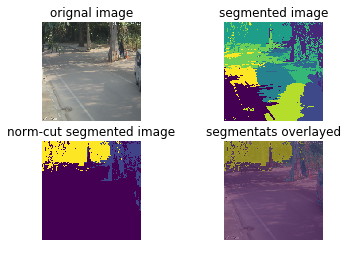

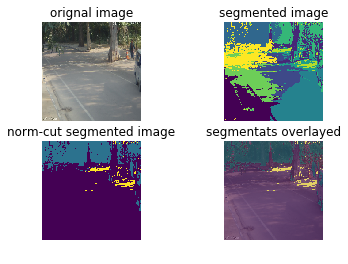

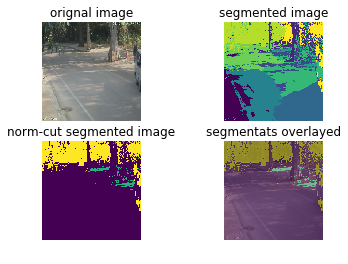

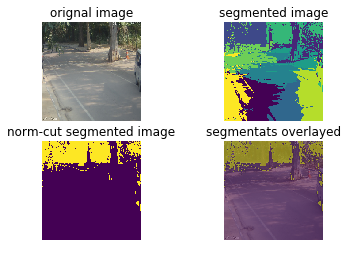

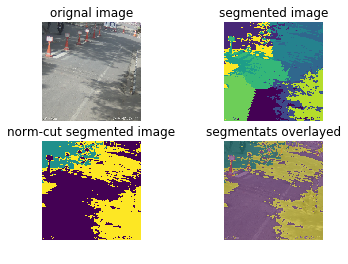

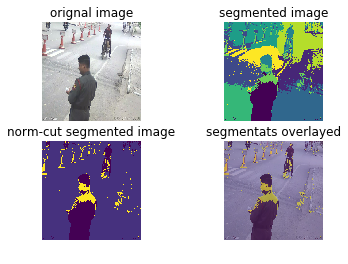

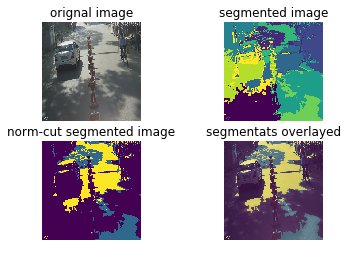

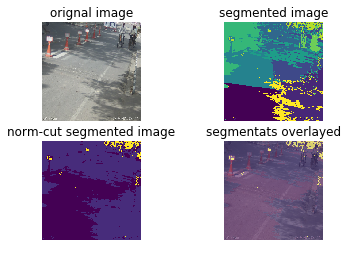

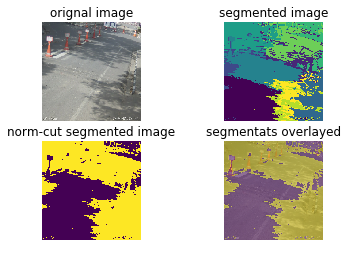

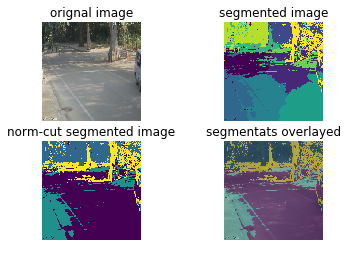

CPU times: user 11.7 s, sys: 1.15 s, total: 12.8 s
Wall time: 11.5 s


In [0]:
%time basic_methods('mini-kmeans',num_clusters = 10)

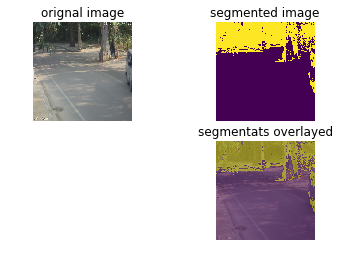

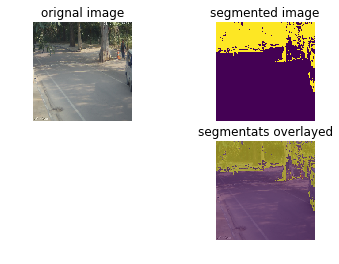

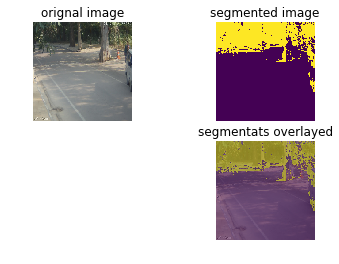

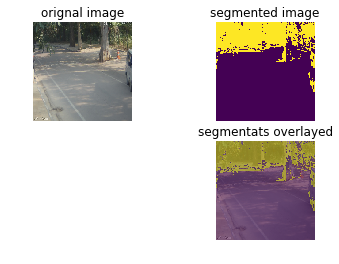

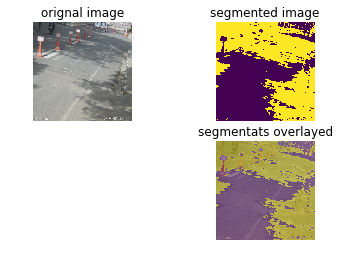

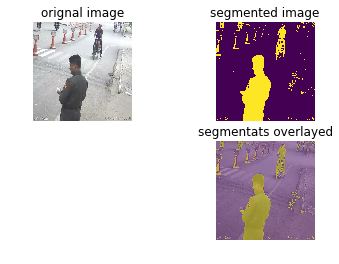

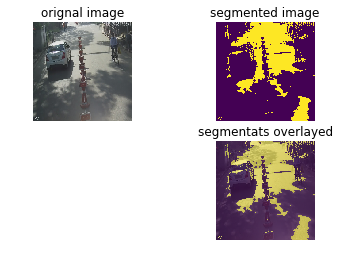

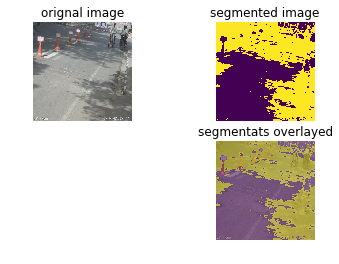

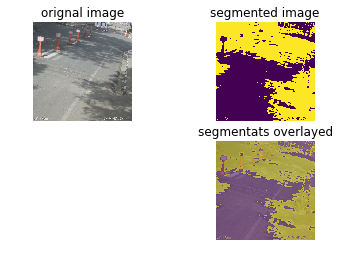

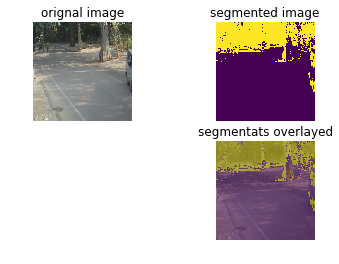

CPU times: user 31.8 s, sys: 2.29 s, total: 34.1 s
Wall time: 31.8 s


In [0]:
%time basic_methods('mean-shift',b_width = 2, norm_c = False)

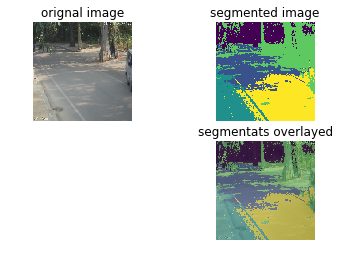

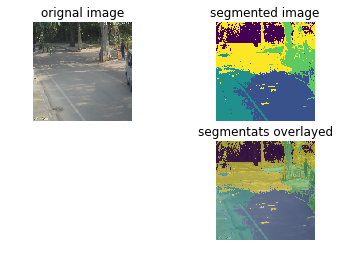

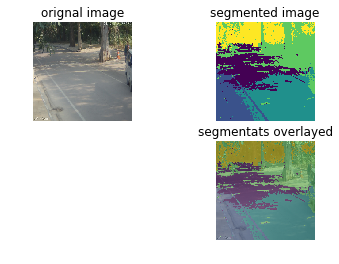

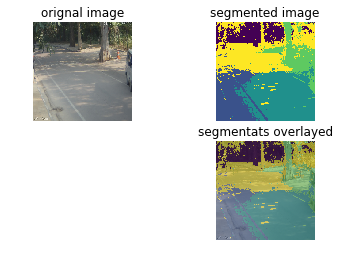

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


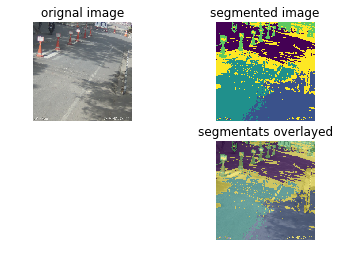

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


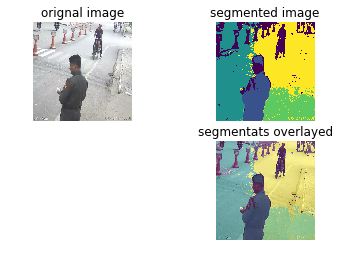

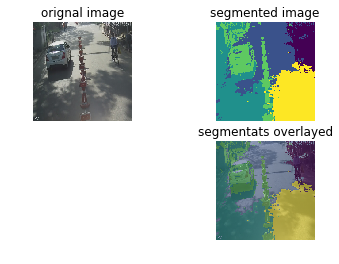

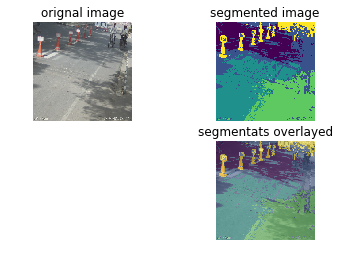

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


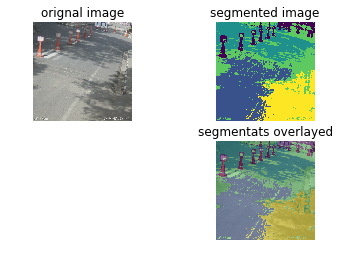

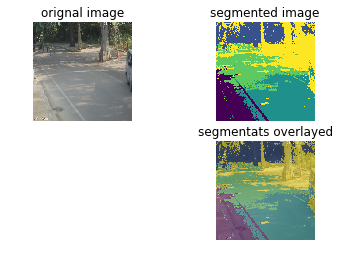

CPU times: user 1min 5s, sys: 39.9 s, total: 1min 45s
Wall time: 54.5 s


In [0]:
%time basic_methods('NBP', num_comp = 5 , norm_c = False)

## Slic based segmentation

This section hosts implementation of slic based segmentation, a convolutional neural network that post processes it afterwards.

### CNN for post processing 

In [0]:
class Model(nn.Module):
    def __init__(self,input_dim, nChannel, nConv):
        
        # input_dim = number of input channel
        # nChannel = number of output channel
        # nConv : number of intermediate convolution layers 
        
        super(Model, self).__init__()
        
        # initial layers
        self.conv1 = nn.Conv2d(input_dim, nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(nChannel)
        self.conv2 = []
        self.bn2 = []
        
        # intermediate layers
        for i in range(nConv-1):
            self.conv2.append( nn.Conv2d(nChannel, nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(nChannel) )
            
        # end layers
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nChannel)
        self.nConv = nConv

    def forward(self, x):
        
        # network flow
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(self.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [0]:
def visualize_img(im, im_target):
    overlay = np.array([label_colours[ c % nchannel ] for c in im_target])
    overlay = overlay.reshape( im.shape ).astype( np.uint8 )
    plt.imshow(im)
    plt.imshow(overlay, alpha=0.5)
    plt.show()

### Build CNN model

In [0]:
# create model 
use_cuda = torch.cuda.is_available()
nchannel = 100
nConv = 2

# cuda enabled model
model = Model(3, nchannel, nConv).cuda()

for i in range(nConv-1):
    model.conv2[i].cuda()
    model.bn2[i].cuda()
        
# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# random colours for labels
label_colours = np.random.randint(255,size=(nchannel,3))

### Slic based segments and its information

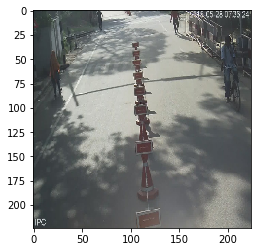

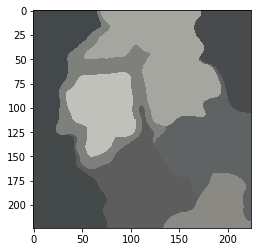

In [0]:
# load image and get its slic based segments

im = load_image('/content/Dataset/camera3/JPEGImages/00008.jpg')
labels = segmentation.slic(im, n_segments=10, sigma = 5)

slic = color.label2rgb(labels, im, kind='avg')
plt.imshow(im)
plt.show()
plt.imshow(slic)

In [0]:
# normalized cut on slic-d segments
g = graph.rag_mean_color(im, labels, mode='similarity')
labels = graph.cut_normalized(labels, g)

# print normalised cut SLIC segment
norm_c_slic = color.label2rgb(labels, im, kind='avg')
plt.imshow(norm_c_slic)

In [0]:
# getting information about labels

unique_lbls = np.unique(labels)

label_indices = []
for i in range(len(unique_lbls)):
    label_indices.append( np.where( labels == unique_lbls[ i ] )[ 0 ] )

# loaded im to pytorch variable
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

### Post Processing

50 / 500 : 17 0.06739944219589233
100 / 500 : 15 0.036357950419187546
150 / 500 : 15 0.02511531673371792
200 / 500 : 15 0.020866526290774345
250 / 500 : 15 0.017828319221735
300 / 500 : 15 0.016035092994570732
350 / 500 : 15 0.014222998172044754
400 / 500 : 15 0.0129769966006279
450 / 500 : 15 0.012079687789082527


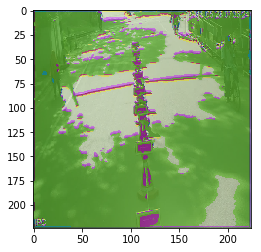

500 / 500 : 15 0.011398387141525745


In [0]:
# post processing of slic based segments

# vars
visualize = 1
maxIter = 500
minLabels = 3

for batch_idx in range(maxIter):
    
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0).contiguous().view( -1, nchannel )
    
    # seg labels
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    
    # coloring and mapping
    for i in range(len(label_indices)):
        labels_per_sp = im_target[ label_indices[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ label_indices[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
        
    target = torch.from_numpy( im_target ).cuda()
    target = Variable( target )
    
    # loss and optim step
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    
    # visualize and print
    if visualize and batch_idx == maxIter - 1:
        visualize_img(im, im_target)
        
    if (batch_idx + 1) % 50 == 0:
        print (batch_idx + 1, '/', maxIter, ':', nLabels, loss.item())
        
    if nLabels <= minLabels:
        print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
        break
        

### Predict segments of the loaded image

In [0]:
# model prediction
output = model( data )[ 0 ]
output = output.permute( 1, 2, 0).contiguous().view( -1, nchannel )

ignore, target = torch.max( output, 1 )
im_target = target.data.cpu().numpy()
visualize_img(im,im_target)